<a href="https://colab.research.google.com/github/jackyang27/DLB_notes/blob/master/RetinaNetTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RetinaNet to TF Serving,Freezing and Optimisation 

Using https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet.ipynb

Running on Docker Container alexcpn/tfserving-keras-retinanet-dev-gpu

Reference 

[1] https://medium.com/google-cloud/optimizing-tensorflow-models-for-serving-959080e9ddbf

[2] https://github.com/tensorflow/tensorflow/tree/master/tensorflow/tools/graph_transforms#optimizing-for-deployment

In [0]:
import tensorflow as tf
import shutil 
import os

In [0]:
# Helper For getting the model Size
import os
from tensorflow.python import ops
def get_size(model_dir, model_file='saved_model.pb'):
  model_file_path = os.path.join(model_dir, model_file)
  print(model_file_path, '')
  pb_size = os.path.getsize(model_file_path)
  variables_size = 0
  if os.path.exists(
      os.path.join(model_dir,'variables/variables.data-00000-of-00001')):
    variables_size = os.path.getsize(os.path.join(
        model_dir,'variables/variables.data-00000-of-00001'))
    variables_size += os.path.getsize(os.path.join(
        model_dir,'variables/variables.index'))
  print('Model size: {} KB'.format(round(pb_size/(1024.0),3)))
  print('Variables size: {} KB'.format(round( variables_size/(1024.0),3)))
  print('Total Size: {} KB'.format(round((pb_size + variables_size)/(1024.0),3)))

In [0]:
# To Freeze the Saved Model
# We need to freeze the model to do further optimisation on it

from tensorflow.python.saved_model import tag_constants
from tensorflow.python.tools import freeze_graph
from tensorflow.python import ops
from tensorflow.tools.graph_transforms import TransformGraph

def freeze_model(saved_model_dir, output_node_names, output_filename):
  output_graph_filename = os.path.join(saved_model_dir, output_filename)
  initializer_nodes = ''
  freeze_graph.freeze_graph(
      input_saved_model_dir=saved_model_dir,
      output_graph=output_graph_filename,
      saved_model_tags = tag_constants.SERVING,
      output_node_names=output_node_names,
      initializer_nodes=initializer_nodes,
      input_graph=None,
      input_saver=False,
      input_binary=False,
      input_checkpoint=None,
      restore_op_name=None,
      filename_tensor_name=None,
      clear_devices=True,
      input_meta_graph=False,
  )


In [0]:
# Source https://medium.com/google-cloud/optimizing-tensorflow-models-for-serving-959080e9ddbf
# Convert the frozen graph to TF model

# Note -You need to change the outputs for your model
# Helper for Converting Frozen graph from Disk to TF serving compatible Model
def get_graph_def_from_file(graph_filepath):
  tf.reset_default_graph()
  with ops.Graph().as_default():
    with tf.gfile.GFile(graph_filepath, 'rb') as f:
      graph_def = tf.GraphDef()
      graph_def.ParseFromString(f.read())
      return graph_def

def convert_graph_def_to_saved_model(export_dir, graph_filepath):

  graph_def = get_graph_def_from_file(graph_filepath)
  with tf.Session(graph=tf.Graph()) as session:
    tf.import_graph_def(graph_def, name='')
    tf.saved_model.simple_save(
        session,
        export_dir,
        inputs={'input_image': session.graph.get_tensor_by_name('{}:0'.format(node.name))
            for node in graph_def.node if node.op=='Placeholder'},
        outputs={t:session.graph.get_tensor_by_name(t) for t in outputs}
                        
                
    )
    print('Optimized graph converted to SavedModel!')

In [0]:
# Optimizing the graph via TensorFlow library
from tensorflow.tools.graph_transforms import TransformGraph


def optimize_graph(model_dir, graph_filename, transforms, output_names, outname='optimized_model.pb'):
  input_names = ['input_image',] # change this as per how you have saved the model
  graph_def = get_graph_def_from_file(os.path.join(model_dir, graph_filename))
  optimized_graph_def = TransformGraph(
      graph_def,
      input_names,  
      output_names,
      transforms)
  tf.train.write_graph(optimized_graph_def,
                      logdir=model_dir,
                      as_text=False,
                      name=outname)
  print('Graph optimized!')

## Section 1 - Installing and running Retinanet - Keras version

In [0]:
#Do this  only once
!git clone --recursive https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [0]:
!cd keras-retinanet && git pull

Already up-to-date.


In [0]:
#Do this only once
!cd keras-retinanet && pip install .  -q

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
#Do this only once
!pip install --upgrade git+https://github.com/broadinstitute/keras-resnet -q

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
# Optional -Do this only once
!pip install Cython
!pip install --user git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI -q

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
^C


In [0]:
#Do this only once if needed
!cd keras-retinanet/snapshots && \
wget https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5

In [0]:
import keras_retinanet.models
import keras_resnet
import keras_retinanet
import tensorflow as tf
import shutil 
import os
import keras

In [0]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

In [0]:
!ls -la keras-retinanet/snapshots

total 298196
drwxrwxr-x 2 1001 1001      4096 Feb 28 10:14 .
drwxrwxr-x 9 1001 1001      4096 Feb 28 14:20 ..
-rw-rw-r-- 1 1001 1001         2 Feb 27 07:45 .gitignore
-rw-r--r-- 1 root root 152662144 Apr 15  2018 resnet50_coco_best_v2.0.3.h5
-rw-r--r-- 1 root root 152662144 Oct 17 11:19 resnet50_coco_best_v2.1.0.h5


In [0]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('keras-retinanet', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')


In [0]:
# load retinanet model
model = keras_retinanet.models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

/usr/local/lib/python2.7/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
# load image and print the shape of the input
image = read_image_bgr('keras-retinanet/examples/000000008021.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)
print image.shape
input = np.expand_dims(image, axis=0)
print input.shape

(800, 1067, 3)
(1, 800, 1067, 3)


('processing time: ', 6.502901077270508)


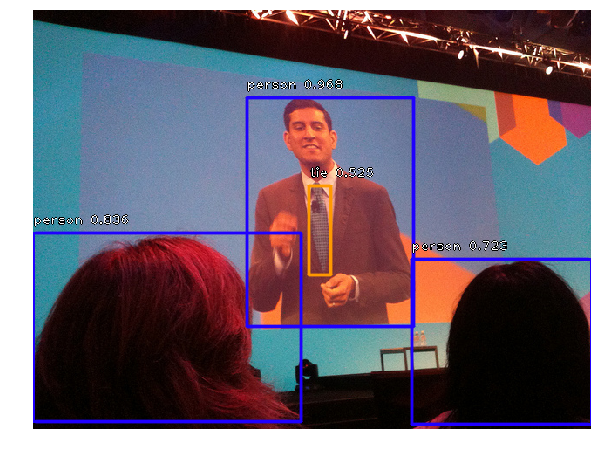

In [0]:
# Run the prediction
# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(draw)
plt.show()

## Section 2 - Saving the Keras Model in TF Serving compatible format

In [0]:
import shutil 
import os
import keras
import tensorflow as tf
from keras.models import load_model


#session = tf.keras.backend.get_session()
session =keras.backend.tensorflow_backend.get_session()

tf.keras.backend.set_learning_phase(0) # Ignore dropout at inference

print("Model file path",model_path)
weightfile = model_path
export_path = os.path.join('keras-retinanet')


if os.path.exists( export_path+"/4"):
    shutil.rmtree( export_path+"/4")
    
export_path = export_path+"/4"

#with tf.keras.backend.get_session() as sess: --> this wont work
with session as sess:
    tf.saved_model.simple_save(
                session,
                export_path,
                inputs={'input_image': model.input},
                outputs={t.name:t for t in model.outputs})


##### Check if saved model is proper

In [0]:
!saved_model_cli show --dir '/coding/IPython_neuralnet/keras-retinanet/4/' --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, -1, -1, 3)
        name: input_1_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 300, 4)
        name: filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0
    outputs['filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 300)
        name: filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0
    outputs['filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3:0'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 300)
        name: filtered_detections/map/TensorArray

### Run TF Serving with the model

#!tensorflow_model_server --model_base_path='/coding/IPython_neuralnet/keras-retinanet/1/' --port=8900 --rest_api_port=8901 --model_name=MnistModel

Run in a container like below

!docker run  --net=host --runtime=nvidia  -it --rm -p 8900:8500 -p 8901:8501 \
       -v /home/alex/coding/:/models/retinanet -e MODEL_NAME=retinanet tensorflow/serving:latest-gpu

For running the client use this docker container
docker run -it --runtime=nvidia  --net=host   -v /home/alex/coding:/coding --rm alexcpn/tfserving-keras-retinanet-dev-gpu
Client gist - below

import grpc
import numpy
import tensorflow as tf

from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
from keras.preprocessing import image
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
import time
import cv2
import numpy as np 

tf.app.flags.DEFINE_integer('concurrency', 1,
                            'maximum number of concurrent inference requests')
tf.app.flags.DEFINE_integer('num_tests', 1, 'Number of test images')
tf.app.flags.DEFINE_string('server', '127.0.0.1:8500', 'PredictionService host:port')
tf.app.flags.DEFINE_string('work_dir', '/tmp', 'Working directory. ')
FLAGS = tf.app.flags.FLAGS

_counter = 0
_start = 0
# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
_response_awaiting = True

def _callback(result_future):
    """Callback function.
    Calculates the statistics for the prediction result.
    Args:
      result_future: Result future of the RPC.
    """
    #print ("Something came - Hee haw")
    global _counter 
    global _start
    global _response_awaiting
   
    exception = result_future.exception()
    if exception:
      print(exception)
   
      """
        Querying the save model gives
          The given SavedModel SignatureDef contains the following output(s):
        outputs['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0'] tensor_info:
            dtype: DT_FLOAT
            shape: (-1, 300, 4)
            name: filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0
        outputs['filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0'] tensor_info:
            dtype: DT_FLOAT
            shape: (-1, 300)
            name: filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0
        outputs['filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3:0'] tensor_info:
            dtype: DT_INT32
            shape: (-1, 300)
            name: filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3:0
      Method name is: tensorflow/serving/predict
      ---
      From retina-net
      In general, inference of the network works as follows:
      boxes, scores, labels = model.predict_on_batch(inputs)
      Where `boxes` are shaped `(None, None, 4)` (for `(x1, y1, x2, y2)`), scores is shaped `(None, None)` (classification score) and labels is shaped `(None, None)` (label corresponding to the score). In all three outputs, the first dimension represents the shape and the second dimension indexes the list of detections.
    """
    parse_result(result_future.result())

def parse_result(result_future):
    """Callback function.
    Calculates the statistics for the prediction result.
    Args:
      result_future: Result future of the RPC.
    """
    global _counter 
    global _start
    global _response_awaiting

    boxes = result_future.\
          outputs['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0']
    scores = result_future.\
          outputs['filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0']
    labels = result_future.\
          outputs['filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3:0']
    boxes= tf.make_ndarray(boxes)
    scores= tf.make_ndarray(scores)
    labels= tf.make_ndarray(labels)

    print("result no",_counter)
    print("boxes output",(boxes).shape)
    print("scores output",(scores).shape)
    print("labels output",(labels).shape)

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.5:
            break
        b = box.astype(int)
        print("Label",labels_to_names[label]," at ",b," Score ",score)
    _counter += 1
    #if( (_counter % 1) ==0):#print every 100
    #  print("[", _counter,"] From Callback Predicted Result is ", prediction,"confidence= ",response[prediction])
    if (_counter == FLAGS.num_tests):
        end = time.time()
        print("Time for ",FLAGS.num_tests," is ",end -_start)
        _response_awaiting = False
 
    
def do_inference(server, work_dir, concurrency, num_tests):    
    channel = grpc.insecure_channel(server)            
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)      
    request = predict_pb2.PredictRequest()                      
    request.model_spec.name = 'retinanet'                        
    request.model_spec.signature_name = 'serving_default'
  
    # Going to read the image
    image = read_image_bgr('../examples/000000008021.jpg')
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    #do this once
    #image= numpy.random.rand(400, 567, 3).astype('f')
    print ("in image shape",image.shape)
    input = np.expand_dims(image, axis=0)
    request.inputs['input_image'].CopyFrom(tf.contrib.util.make_tensor_proto \
      (input, shape=[1, 800, 1067, 3]))
    #request.inputs['input_image'].CopyFrom(tf.contrib.util.make_tensor_proto \
    # (input, shape=[1, 500, 567, 3]))
     
    global _start
    _start = time.time()
    global _response_awaiting
    _response_awaiting =True
    for i in range(num_tests):
      #print("Going to send the request")
      # for testing speed
      #image= numpy.random.rand(800, 1067, 3).astype('f')
      
      #input = np.expand_dims(image, axis=0)
      
      #input_data = []
      #input_data.append(input)
      #request.inputs['input_image'].CopyFrom(tf.contrib.util.make_tensor_proto(input_data, shape=[len(input_data)]))

      #request.inputs['input_image'].CopyFrom(tf.contrib.util.make_tensor_proto \
      #  (input, shape=[1, 800, 1067, 3]))
      
      # call back way - this is faster
      result_future = stub.Predict.future(request, 20.25)  # Intial takes time  
      result_future.add_done_callback(_callback)

      # request reponse way - this is slower
      # result = stub.Predict(request, 10.25)  #  seconds  
      # parse_result(result)
      _response_awaiting = True

      #print("Send the request")

    while(_response_awaiting):
      time.sleep(.000010)
    print("Response Received Exiting")




def main(_):
  if not FLAGS.num_tests:
      print('Please specify num_tests -num_tests=n')
      return
  if not FLAGS.server:
    print('please specify server -server host:port')
    return
  print("Number of test=",FLAGS.num_tests)
  error_rate = do_inference(FLAGS.server, FLAGS.work_dir,
                            FLAGS.concurrency, FLAGS.num_tests) 
          
if __name__ == '__main__':
    print ("hello from TFServing  v2 client slim < -num_tests -server>")
    tf.app.run()

## Section 3 - Convert the Saved model for Freezing (for Optimizations)

In [0]:
# Try to load the saved model
tf.keras.backend.clear_session()
session = tf.Session()
import_path = os.path.join('keras-retinanet/4')
                           
meta =tf.saved_model.loader.load(
            session,
            [tf.saved_model.tag_constants.SERVING],
        import_path )

output_node_names = u'filtered_detections/map/TensorArrayStack/TensorArrayGatherV3,\
filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3,     \
filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3'

freeze_model('keras-retinanet/4/', output_node_names, '../5/freezed_model.pb')

INFO:tensorflow:Restoring parameters from keras-retinanet/4/variables/variables


In [0]:
# Optional - For displaying in TensorBoard
# https://github.com/tensorflow/tensorboard/blob/master/README.md

graph = tf.get_default_graph()
file_writer = tf.summary.FileWriter('/coding/IPython_notebook/keras-retinanet/logs', session.graph)

In [0]:
get_size('keras-retinanet/4/',model_file='saved_model.pb')
print "------------------------------------"
get_size('keras-retinanet/5/',model_file='freezed_model.pb')
print "-------------------------------------"
print "saved frozen model"
get_size('keras-retinanet/7/',model_file='saved_model.pb')

('keras-retinanet/4/saved_model.pb', '')
Model size: 1789.223 KB
Variables size: 201138.84 KB
Total Size: 202928.063 KB
------------------------------------
('keras-retinanet/5/freezed_model.pb', '')
Model size: 149485.126 KB
Variables size: 0.0 KB
Total Size: 149485.126 KB
-------------------------------------
saved frozen model
('keras-retinanet/7/saved_model.pb', '')
Model size: 149500.15 KB
Variables size: 0.0 KB
Total Size: 149500.15 KB


### Section 4 - Convert Frozen model to TF Serving

In [0]:
# You need to change the outputs for your model
outputs = ['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0',\
'filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0',     \
'filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3:0']

In [0]:
#Lets load a frozen model
gdef =get_graph_def_from_file('keras-retinanet/5/freezed_model.pb')
convert_graph_def_to_saved_model('keras-retinanet/xx/', 'keras-retinanet/5/freezed_model.pb')

In [0]:
# Helper Run this to get the node names in the graph
# useful to get the node names to be used in framing the output 
node_names = [node.name for node in gdef.node]
print node_names

### Section 5 - Optimising the Frozen model

In [0]:
# Optimization without Qunatization
transforms = ['remove_nodes(op=Identity)', \
 'merge_duplicate_nodes', \
 'strip_unused_nodes',
 'fold_constants(ignore_errors=true)',
 'fold_batch_norms',
 'quantize_weights'] #this reduces the size, but there is no speed up , actaully slows down, see below
output_node_names = ['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3',\
'filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3',     
'filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3']

optimize_graph('keras-retinanet/5/', 'freezed_model.pb' , transforms, output_node_names,outname='optimized_model_simple.pb')

Graph optimized!


In [0]:
# see https://medium.com/google-cloud/optimizing-tensorflow-models-for-serving-959080e9ddbf
print "Optimised models"
get_size('keras-retinanet/5/',model_file='optimized_model_simple.pb') 

# Only weights are quanized - not faster actually slower though size has decreased to just 37 MB from 149 MB!!
# Also accuracy seems also to be similar
#('Time for ', 10, ' is ', 0.6285901069641113) Non optimized v100
#('Time for ', 10, ' is ', 0.6342859268188477) - after optimization but without quanization
#('Time for ', 10, ' is ', 1.1140730381011963) After weight quantization  - time became almost doub;e

#"This process converts all the operations in the graph that have eight-bit quantized equivalents, 
#and leaves the rest in floating point. Only a subset of ops are supported, and on many platforms 
#the quantized code may actually be slower than the float equivalents, 
#but this is a way of increasing performance substantially when all the circumstances are right.
# from https://github.com/tensorflow/tensorflow/tree/master/tensorflow/tools/graph_transforms#optimizing-for-deployment


Optimised models
('keras-retinanet/5/optimized_model_simple.pb', '')
Model size: 37923.284 KB
Variables size: 0.0 KB
Total Size: 37923.284 KB


In [0]:
# You need to change the outputs for your model
outputs = ['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0',\
'filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0',     \
'filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3:0']

In [0]:
export_path = os.path.join('keras-retinanet')
if os.path.exists( export_path+"/6"):
    shutil.rmtree( export_path+"/6")
convert_graph_def_to_saved_model('keras-retinanet/6/', 'keras-retinanet/5/optimized_model_simple.pb')

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: keras-retinanet/6/saved_model.pb
Optimized graph converted to SavedModel!


In [0]:
#this should really covert also the calculation to lower precision - but does not work as of  now
    
transforms = ['add_default_attributes', \
  'strip_unused_nodes', \
  'remove_nodes(op=Identity, op=CheckNumerics)',\
  'fold_constants(ignore_errors=true)',
  'fold_batch_norms',
  'fold_old_batch_norms',
  'quantize_weights',
#  'quantize_nodes',
  'strip_unused_nodes',
  'sort_by_execution_order']

output_node_names = ['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3',\
'filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3',     
'filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3']

optimize_graph('keras-retinanet/5/', 'freezed_model.pb' , transforms, output_node_names,outname='optimized_model_weights.pb')

Graph optimized!


In [0]:
export_path = os.path.join('keras-retinanet')
if os.path.exists( export_path+"/7"):
    shutil.rmtree( export_path+"/7")
convert_graph_def_to_saved_model('keras-retinanet/7/', 'keras-retinanet/5/optimized_model_weights.pb')

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: keras-retinanet/7/saved_model.pb
Optimized graph converted to SavedModel!


In [0]:
#this should really covert also the calculation to lower precision - but does not work as of  now
    
transforms = ['add_default_attributes', \
  'strip_unused_nodes', \
  'remove_nodes(op=Identity, op=CheckNumerics)',\
  'fold_constants(ignore_errors=true)',
  'fold_batch_norms',
  'fold_old_batch_norms',
  'quantize_weights',
  'quantize_nodes',
  'strip_unused_nodes',
  'sort_by_execution_order']

output_node_names = ['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3',\
'filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3',     
'filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3']

optimize_graph('keras-retinanet/5/', 'freezed_model.pb' , transforms, output_node_names,outname='optimized_model_all.pb')

Graph optimized!


In [0]:
# see https://medium.com/google-cloud/optimizing-tensorflow-models-for-serving-959080e9ddbf
print "Optimised models"
get_size('keras-retinanet/5/',model_file='optimized_model_all.pb') #also nodes quantized

Optimised models
('keras-retinanet/5/optimized_model_all.pb', '')
Model size: 38121.404 KB
Variables size: 0.0 KB
Total Size: 38121.404 KB


In [0]:
export_path = os.path.join('keras-retinanet')
if os.path.exists( export_path+"/8"):
    shutil.rmtree( export_path+"/8")
convert_graph_def_to_saved_model('keras-retinanet/8/', 'keras-retinanet/5/optimized_model_all.pb')

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: keras-retinanet/8/saved_model.pb
Optimized graph converted to SavedModel!


In [0]:
print "------------------------------------"
print "saved  model TF Serving from Keras Model"
get_size('keras-retinanet/4/',model_file='saved_model.pb')
print "------------------------------------"
print "saved  model Frozen Model"
get_size('keras-retinanet/5/',model_file='freezed_model.pb')
print "-------------------------------------"
print "saved  model Simple Optimisation"
get_size('keras-retinanet/6/',model_file='saved_model.pb')
print "-------------------------------------"
print "saved  model Weight Optimisation"
get_size('keras-retinanet/7/',model_file='saved_model.pb')
print "-------------------------------------"
print "saved  model Weight and Model Optimisation"
get_size('keras-retinanet/8/',model_file='saved_model.pb')


------------------------------------
saved  model TF Serving from Keras Model
('keras-retinanet/4/saved_model.pb', '')
Model size: 1789.223 KB
Variables size: 201138.84 KB
Total Size: 202928.063 KB
------------------------------------
saved  model Frozen Model
('keras-retinanet/5/freezed_model.pb', '')
Model size: 149485.126 KB
Variables size: 0.0 KB
Total Size: 149485.126 KB
-------------------------------------
saved  model Simple Optimisation
('keras-retinanet/6/saved_model.pb', '')
Model size: 37947.687 KB
Variables size: 0.0 KB
Total Size: 37947.687 KB
-------------------------------------
saved  model Weight Optimisation
('keras-retinanet/7/saved_model.pb', '')
Model size: 38011.329 KB
Variables size: 0.0 KB
Total Size: 38011.329 KB
-------------------------------------
saved  model Weight and Model Optimisation
('keras-retinanet/8/saved_model.pb', '')
Model size: 38228.044 KB
Variables size: 0.0 KB
Total Size: 38228.044 KB


### Optimize via NIVDIA TensoRT
Base - https://docs.nvidia.com/deeplearning/dgx/integrate-tf-trt/index.html +
https://developers.googleblog.com/2018/03/tensorrt-integration-with-tensorflow.html

In [0]:
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt

In [0]:

# You need to change the outputs for your model
outputs = ['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0',\
'filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0',     \
'filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3:0']


In [0]:
# Inference with TF-TRT `SavedModel` workflow:

export_path = os.path.join('keras-retinanet')
if os.path.exists( export_path+"/9"):
    shutil.rmtree( export_path+"/9")
    
export_path = export_path+"/9"


tf.reset_default_graph()
graph = tf.Graph()
sess = tf.Session()
# Create a TensorRT inference graph from a SavedModel:
with graph.as_default():
    with tf.Session() as sess:
        trt_graph = trt.create_inference_graph(
            input_graph_def=None,
            outputs=outputs,
            input_saved_model_dir='keras-retinanet/4/',
            input_saved_model_tags=['serve'],
            max_batch_size=1,
            max_workspace_size_bytes=7000000000,
            #precision_mode='FP16') 
            precision_mode='FP32')
            #precision_mode='INT8')
        output_node=tf.import_graph_def(trt_graph, return_elements=outputs)
        #sess.run(output_node)
        tf.saved_model.simple_save(sess,
        export_path,
        inputs={'input_image': graph.get_tensor_by_name('{}:0'.format(node.name))
            for node in graph.as_graph_def().node if node.op=='Placeholder'},
        outputs={t:graph.get_tensor_by_name('import/'+t) for t in outputs}
    
    )

INFO:tensorflow:Running against TensorRT version 0.0.0
INFO:tensorflow:Restoring parameters from keras-retinanet/4/variables/variables
INFO:tensorflow:Froze 306 variables.
INFO:tensorflow:Converted 306 variables to const ops.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: keras-retinanet/9/saved_model.pb


In [0]:
!saved_model_cli show --dir 'keras-retinanet/9/' --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, -1, -1, 3)
        name: import/input_1_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0'] tensor_info:
        dtype: DT_FLOAT
        shape: unknown_rank
        name: import/filtered_detections/map/TensorArrayStack/TensorArrayGatherV3:0
    outputs['filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0'] tensor_info:
        dtype: DT_FLOAT
        shape: unknown_rank
        name: import/filtered_detections/map/TensorArrayStack_1/TensorArrayGatherV3:0
    outputs['filtered_detections/map/TensorArrayStack_2/TensorArrayGatherV3:0'] tensor_info:
        dtype: DT_INT32
        shape: unknown_rank
        name: import/f

In [0]:
# Inference with TF-TRT `Frozen` workflow:
# https://medium.com/tensorflow/speed-up-tensorflow-inference-on-gpus-with-tensorrt-13b49f3db3fa

export_path = os.path.join('keras-retinanet')
if os.path.exists( export_path+"/10"):
    shutil.rmtree( export_path+"/10")
    
export_path = export_path+"/10"

#Lets load a frozen model
gdef =get_graph_def_from_file('keras-retinanet/5/freezed_model.pb')

tf.reset_default_graph()
graph = tf.Graph()
sess = tf.Session()
# Create a TensorRT inference graph from a SavedModel:
with graph.as_default():
    with tf.Session() as sess:
        trt_graph = trt.create_inference_graph(
            input_graph_def=gdef,
            outputs=outputs,
            max_batch_size=1,
            max_workspace_size_bytes=7000000000,
            precision_mode='FP16') 
            #precision_mode='FP32')
            #precision_mode='INT8')
        output_node=tf.import_graph_def(trt_graph, return_elements=outputs)
        #sess.run(output_node)
        tf.saved_model.simple_save(sess,
        export_path,
        inputs={'input_image': graph.get_tensor_by_name('{}:0'.format(node.name))
            for node in graph.as_graph_def().node if node.op=='Placeholder'},
        outputs={t:graph.get_tensor_by_name('import/'+t) for t in outputs}
    
    )

INFO:tensorflow:Running against TensorRT version 0.0.0
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: keras-retinanet/10/saved_model.pb


In [0]:
# Inference with TF-TRT `Frozen` workflow:
# https://medium.com/tensorflow/speed-up-tensorflow-inference-on-gpus-with-tensorrt-13b49f3db3fa

export_path = os.path.join('keras-retinanet')
if os.path.exists( export_path+"/11"):
    shutil.rmtree( export_path+"/11")
    
export_path = export_path+"/11"

#Lets load a frozen model
gdef =get_graph_def_from_file('keras-retinanet/5/freezed_model.pb')

tf.reset_default_graph()
graph = tf.Graph()
sess = tf.Session()
# Create a TensorRT inference graph from a SavedModel:
with graph.as_default():
    with tf.Session() as sess:
        trt_graph = trt.create_inference_graph(
            input_graph_def=gdef,
            outputs=outputs,
            max_batch_size=1,
            max_workspace_size_bytes=7000000000,
            #precision_mode='FP16') 
            #precision_mode='FP32')
            precision_mode='INT8')
        output_node=tf.import_graph_def(trt_graph, return_elements=outputs)
        #sess.run(output_node)
        tf.saved_model.simple_save(sess,
        export_path,
        inputs={'input_image': graph.get_tensor_by_name('{}:0'.format(node.name))
            for node in graph.as_graph_def().node if node.op=='Placeholder'},
        outputs={t:graph.get_tensor_by_name('import/'+t) for t in outputs}
    
    )

INFO:tensorflow:Running against TensorRT version 0.0.0
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: keras-retinanet/11/saved_model.pb


In [0]:
print "---------NVIDIA RT Optimised model FP32"
get_size('keras-retinanet/9/',model_file='saved_model.pb') #also nodes quantized
print "---------NVIDIA RT Optimised model FP16"
get_size('keras-retinanet/10/',model_file='saved_model.pb') #also nodes quantized
print "-------NVIDIA RT Optimised model INT8"
get_size('keras-retinanet/11/',model_file='saved_model.pb') #also nodes quantized

---------NVIDIA RT Optimised model FP32
('keras-retinanet/9/saved_model.pb', '')
Model size: 149522.778 KB
Variables size: 0.0 KB
Total Size: 149522.778 KB
---------NVIDIA RT Optimised model FP16
('keras-retinanet/10/saved_model.pb', '')
Model size: 149522.778 KB
Variables size: 0.0 KB
Total Size: 149522.778 KB
-------NVIDIA RT Optimised model INT8
('keras-retinanet/11/saved_model.pb', '')
Model size: 149522.778 KB
Variables size: 0.0 KB
Total Size: 149522.778 KB
